              Age  Sleep_Hours  Stress_Level  Age_Menarche  Period_Duration  \
count  500.000000   500.000000    500.000000    500.000000       500.000000   
mean    29.782000     6.969800      4.954000     12.542000         4.640000   
std      9.256232     1.756781      2.580155      1.722257         1.681683   
min     15.000000     4.000000      1.000000     10.000000         2.000000   
25%     21.000000     5.400000      3.000000     11.000000         3.000000   
50%     30.000000     7.000000      5.000000     13.000000         5.000000   
75%     38.000000     8.500000      7.000000     14.000000         6.000000   
max     44.000000    10.000000      9.000000     15.000000         7.000000   

        Height_cm   Weight_kg         BMI  Waist_Hip_Ratio  
count  500.000000  500.000000  500.000000       500.000000  
mean   160.149200   72.489400   28.710400         0.848860  
std     11.377266   15.939481    7.685351         0.086755  
min    140.000000   45.400000   14.200000   

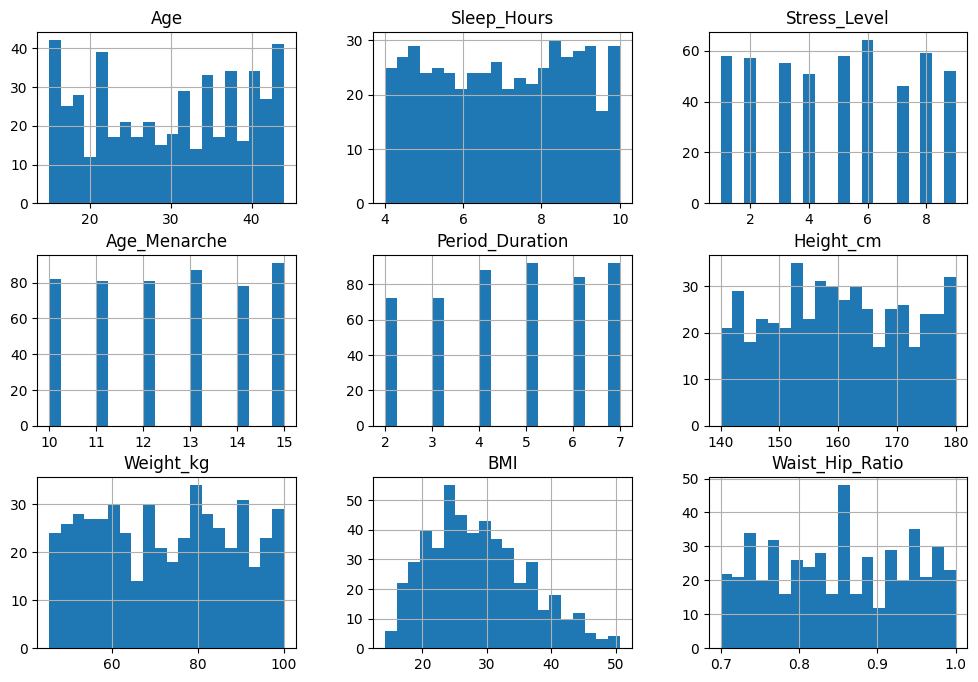

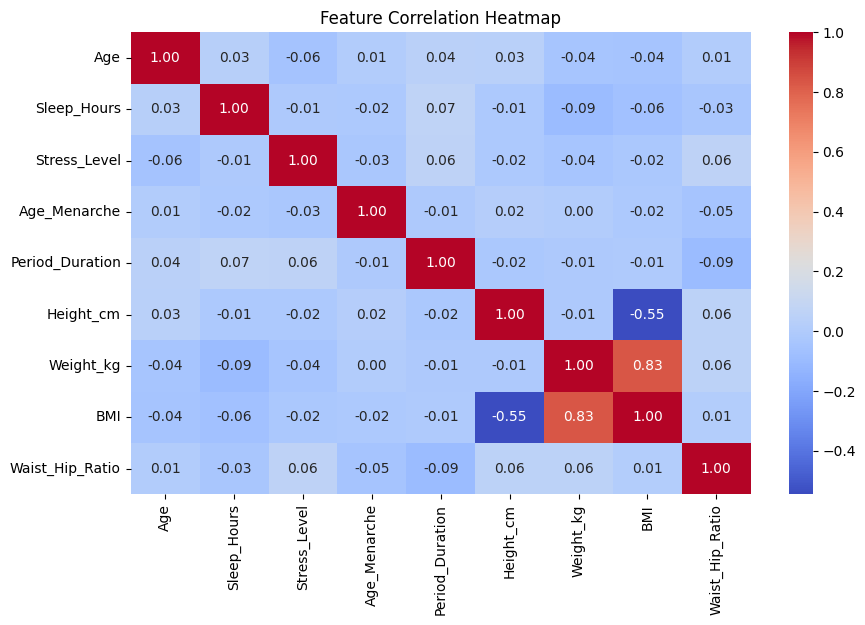

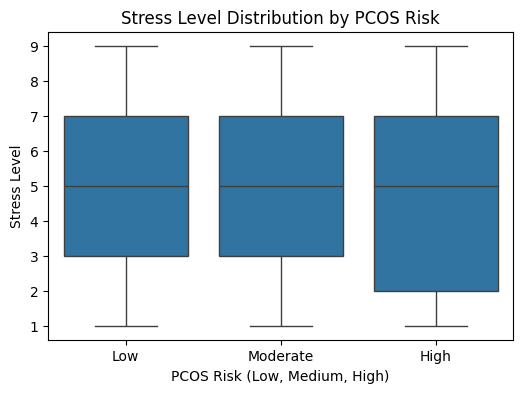

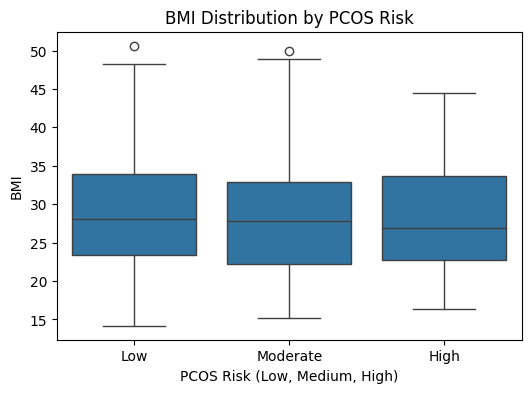

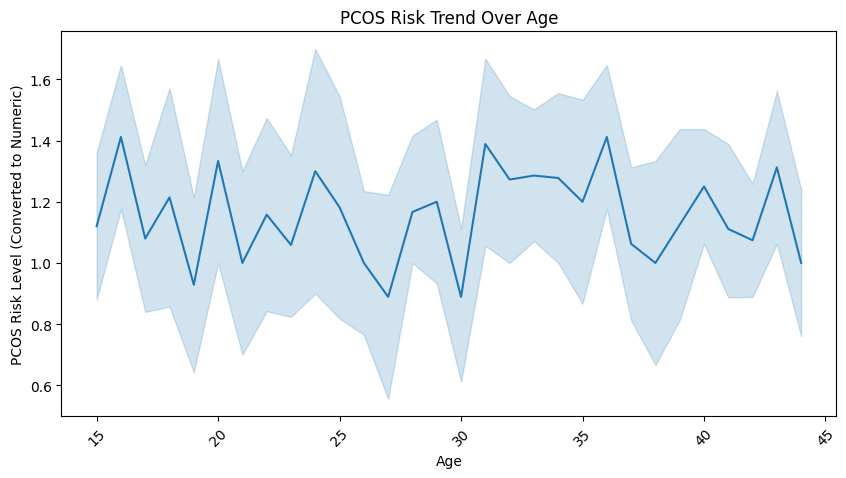

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("PCOS_Non_Clinical_Dataset.csv")

# Basic statistics for numerical features
print(df.describe())

# Distribution of numerical features
df.hist(figsize=(12, 8), bins=20)
plt.show()

# Correlation heatmap (only for numerical features)
plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Boxplot: Stress Level vs PCOS Risk
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['PCOS_Risk'], y=df['Stress_Level'])
plt.xlabel("PCOS Risk (Low, Medium, High)")
plt.ylabel("Stress Level")
plt.title("Stress Level Distribution by PCOS Risk")
plt.show()

# Boxplot: BMI vs PCOS Risk
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['PCOS_Risk'], y=df['Weight_kg'] / (df['Height_cm'] / 100) ** 2)  # BMI calculation
plt.xlabel("PCOS Risk (Low, Medium, High)")
plt.ylabel("BMI")
plt.title("BMI Distribution by PCOS Risk")
plt.show()

# Line plot: PCOS Risk over Age
plt.figure(figsize=(10, 5))
sns.lineplot(x=df['Age'], y=pd.Categorical(df['PCOS_Risk']).codes)  # Convert categorical risk to numerical codes
plt.title("PCOS Risk Trend Over Age")
plt.xlabel("Age")
plt.ylabel("PCOS Risk Level (Converted to Numeric)")
plt.xticks(rotation=45)
plt.show()


In [7]:
import pandas as pd
import numpy as np
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb

# Load dataset
data = pd.read_csv("PCOS_Non_Clinical_Dataset.csv")

# Define target variable
target_column = 'PCOS_Risk'
if target_column not in data.columns:
    raise ValueError(f"Target column '{target_column}' not found in dataset.")

# Feature Engineering: Create BMI
if "Height_cm" in data.columns and "Weight_kg" in data.columns:
    data["BMI"] = data["Weight_kg"] / (data["Height_cm"] / 100) ** 2

# Separate features and target
X = data.drop(columns=[target_column])
y = data[target_column]

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Encode target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Handle missing values and scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Encode categorical variables
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Apply transformations
X_processed = preprocessor.fit_transform(X)

# Perform PCA
pca = PCA(n_components=0.95)  # Keep 95% variance
X_pca = pca.fit_transform(X_processed)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Handle class imbalance
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Feature selection
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

# Define models with hyperparameter tuning
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "SVM (Linear Kernel)": SVC(kernel='linear', random_state=42),
    "SVM (RBF Kernel)": SVC(kernel='rbf', random_state=42, probability=True, C=10, gamma=0.1),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=300, max_depth=15),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42, n_estimators=300, learning_rate=0.05),
    "XGBoost": xgb.XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=10, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=7),
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=15),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(200, 100), activation='relu', solver='adam', max_iter=1000, random_state=42),
    "AdaBoost": AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42), random_state=42),
    "Bagging (Decision Tree)": BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), random_state=42),
    "Voting Classifier (Hard)": VotingClassifier(estimators=[
        ("Logistic Regression", LogisticRegression(random_state=42, max_iter=1000)),
        ("SVM", SVC(kernel='rbf', probability=True, random_state=42)),
        ("Decision Tree", DecisionTreeClassifier(random_state=42))
    ], voting='hard'),
    "Voting Classifier (Soft)": VotingClassifier(estimators=[
        ("Logistic Regression", LogisticRegression(random_state=42, max_iter=1000)),
        ("SVM", SVC(kernel='rbf', probability=True, random_state=42)),
        ("Decision Tree", DecisionTreeClassifier(random_state=42))
    ], voting='soft')
}

# Train and evaluate models
results = {}
print("\n--- Evaluating Traditional Models ---\n")
for name, model in models.items():
    print(f"Training and evaluating: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

# Save best model & preprocessing objects
best_model_name = max(results, key=results.get)
best_model = models.get(best_model_name, models["Voting Classifier (Soft)"])

joblib.dump(best_model, "best_model.pkl")
joblib.dump(preprocessor, "preprocessor.pkl")
joblib.dump(pca, "pca.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")
joblib.dump(selector, "feature_selector.pkl")

print(f"Best model ({best_model_name}) saved successfully with accuracy: {results[best_model_name]:.4f}")



--- Evaluating Traditional Models ---

Training and evaluating: Logistic Regression
Accuracy: 0.9600
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        31
           1       0.80      1.00      0.89        12
           2       1.00      0.93      0.96        57

    accuracy                           0.96       100
   macro avg       0.92      0.98      0.95       100
weighted avg       0.97      0.96      0.96       100

--------------------------------------------------
Training and evaluating: SVM (Linear Kernel)
Accuracy: 0.9500
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       0.75      1.00      0.86        12
           2       0.98      0.93      0.95        57

    accuracy                           0.95       100
   macro avg       0.91      0.97      0.93       100
weighted avg       0.96      0.9